4x4부터 256x256까지 해상도를 높이며 학습하고, fake이미지를 생성한다.

현재, 32x32 학습 중에 생성자Loss값이 0이되고, 판별자Loss값이 50이 되면서 학습이 안되는 문제가 발생했다.(아래 그래프 참고)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd drive/MyDrive/SteelData/severstal-steel-defect-detection/

/content/drive/MyDrive/SteelData/severstal-steel-defect-detection


In [ ]:
ls

crop_defect2/           defect_pggan_generated_images/  test_images/  train_image/
dataset/                model_state_dict/               train/        train_log/
defect4_pggan_1차시도/  new_train.csv                   train.csv     train_log_defect2_rgb/
defect_class/           sample_submission.csv           train.gsheet


train과 val로 학습하고자 하는 결함 이미지를 8:2로 나누어 저장한다. 여기서는 defect4로 진행한다.

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# 원본 이미지가 저장된 디렉토리
src_dir = "defect_class/crop_defect4/defect4_cropped"

# 훈련 세트와 검증 세트가 저장될 디렉토리
train_dir = "dataset/train/defect4"
val_dir = "dataset/val/defect4"

# 원본 이미지 파일 리스트 생성
file_list = os.listdir(src_dir)

# 파일 리스트를 훈련 리스트와 검증 리스트로 분할 (비율 8:2)
train_list, val_list = train_test_split(file_list, test_size=0.2)

# 각각의 리스트에 대한 파일을 적절한 폴더로 이동

for file_name in train_list:
    shutil.copy(os.path.join(src_dir, file_name), os.path.join(train_dir, file_name))

for file_name in val_list:
    shutil.copy(os.path.join(src_dir, file_name), os.path.join(val_dir, file_name))


model을 정의한다.

In [ ]:
# models file was referred to "https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master/ML/Pytorch/GANs/ProGAN".

import torch
import torch.nn as nn
import torch.nn.functional as F

channel_list = [128, 128, 128, 128, 64, 32, 16]



class WSConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, gain=2):
        super().__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.scale = (gain / (in_channels * kernel_size ** 2)) ** 0.5

        # self.bias.shape: (out_channels)
        self.bias = self.conv.bias
        self.conv.bias = None

        nn.init.normal_(self.conv.weight)
        nn.init.zeros_(self.bias)


    def forward(self, x):
        out = self.conv(x * self.scale) + self.bias.view(1, self.bias.shape[0], 1, 1)
        return out



class PixelNorm(nn.Module):

    def __init__(self):
        super().__init__()
        self.epsilon = 1e-8


    def forward(self, x):
        # (batch_size, C, H, W) / (batch_size, 1, H, W)
        out = x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + self.epsilon)
        return out



class UpDownSampling(nn.Module):

    def __init__(self, size):
        super().__init__()
        self.size = size


    def forward(self, x):
        out = F.interpolate(x, scale_factor=self.size, mode="nearest")
        return out



class GeneratorConvBlock(nn.Module):

    def __init__(self, step, scale_size):
        super().__init__()
        self.up_sampling = UpDownSampling(size=scale_size)

        # (C_(step-1), H, W) -> (C_step, H, W)
        self.conv1 = WSConv2d(in_channels=channel_list[step-1], out_channels=channel_list[step], kernel_size=3, stride=1, padding=1)

        # (C_step, H, W) -> (C_step, H, W)
        self.conv2 = WSConv2d(in_channels=channel_list[step], out_channels=channel_list[step], kernel_size=3, stride=1, padding=1)

        self.leakyrelu = nn.LeakyReLU(0.2)

        self.pn = PixelNorm()


    def forward(self, x):
        self.scaled = self.up_sampling(x)

        out = self.conv1(self.scaled)
        out = self.leakyrelu(out)
        out = self.pn(out)

        out = self.conv2(out)
        out = self.leakyrelu(out)
        out = self.pn(out)

        return out



class Generator(nn.Module):

    def __init__(self, steps):
        super().__init__()

        self.steps = steps

        self.init = nn.Sequential(
            PixelNorm(),

            # (z_dim, 1, 1) -> (C_0, 4, 4)
            nn.ConvTranspose2d(in_channels=channel_list[0], out_channels=channel_list[0], kernel_size=4, stride=1, padding=0),
            nn.LeakyReLU(0.2),

            # (C_0, 4, 4) -> (C_0, 4, 4)
            WSConv2d(in_channels=channel_list[0], out_channels=channel_list[0], kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            PixelNorm()
        )

        self.init_torgb = WSConv2d(in_channels=channel_list[0], out_channels=1, kernel_size=1, stride=1, padding=0)

        self.prog_blocks = nn.ModuleList([self.init])
        self.torgb_layers = nn.ModuleList([self.init_torgb])

        # append blocks that are not init block.
        for step in range(1, self.steps+1):
            self.prog_blocks.append(GeneratorConvBlock(step, scale_size=2))
            self.torgb_layers.append(WSConv2d(in_channels=channel_list[step], out_channels=1, kernel_size=1, stride=1, padding=0))


    def fade_in(self, alpha, upsampling, generated):
        return alpha * generated + (1 - alpha) * upsampling


    def forward(self, x, alpha):
        out = self.prog_blocks[0](x)

        if self.steps == 0:
            return self.torgb_layers[0](out)

        for step in range(1, self.steps+1):
            out = self.prog_blocks[step](out)

        upsampling = self.torgb_layers[step-1](self.prog_blocks[step].scaled)
        generated = self.torgb_layers[step](out)

        return self.fade_in(alpha, upsampling, generated)



class DiscriminatorConvBlock(nn.Module):

    def __init__(self, step):
        super().__init__()

        # (C_step, H, W) -> (C_step, H, W)
        self.conv1 = WSConv2d(in_channels=channel_list[step], out_channels=channel_list[step], kernel_size=3, stride=1, padding=1)

        # (C_step, H, W) -> (C_(step-1), H, W)
        self.conv2 = WSConv2d(in_channels=channel_list[step], out_channels=channel_list[step-1], kernel_size=3, stride=1, padding=1)

        # (C_(step-1), H/2, W/2)
        self.downsample = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

        self.leakyrelu = nn.LeakyReLU(0.2)


    def forward(self, x):
        out = self.conv1(x)
        out = self.leakyrelu(out)

        out = self.conv2(out)
        out = self.leakyrelu(out)

        out = self.downsample(out)

        return out



class MinibatchStd(nn.Module):

    def __init__(self):
        super().__init__()


    def forward(self, x):
        # mean of minibatch's std
        # (1) -> (batch_size, 1, H, W)
        batch_statistics = (torch.std(x, dim=0).mean().repeat(x.size(0), 1, x.size(2), x.size(3)))

        # (batch_size, C, H, W) -> (batch_size, C+1, H, W)
        return torch.cat((x, batch_statistics), dim=1)



class Discriminator(nn.Module):

    def __init__(self, steps):
        super().__init__()
        # progressive growing blocks
        self.prog_blocks = nn.ModuleList([])

        # fromrgb layers
        self.fromrgb_layers = nn.ModuleList([])

        self.leakyrelu = nn.LeakyReLU(0.2)

        self.steps = steps

        # append blocks that are not final block.
        for step in range(steps, 0, -1):
            self.prog_blocks.append(DiscriminatorConvBlock(step))
            self.fromrgb_layers.append(WSConv2d(in_channels=1, out_channels=channel_list[step], kernel_size=1, stride=1, padding=0))

        # append final block
        self.fromrgb_layers.append(
            WSConv2d(in_channels=1, out_channels=channel_list[0], kernel_size=1, stride=1, padding=0)
        )

        # append final block
        self.prog_blocks.append(
            nn.Sequential(
                MinibatchStd(),
                WSConv2d(in_channels=channel_list[0]+1, out_channels=channel_list[0], kernel_size=3, stride=1, padding=1),
                nn.LeakyReLU(0.2),
                WSConv2d(in_channels=channel_list[0], out_channels=channel_list[0], kernel_size=4, stride=1, padding=0),
                nn.LeakyReLU(0.2),
                WSConv2d(in_channels=channel_list[0], out_channels=1, kernel_size=1, stride=1, padding=0),
                nn.Sigmoid()
            )
        )

        # downsample
        self.avgpool = nn.AvgPool2d(kernel_size=2, stride=2)


    def fade_in(self, alpha, downscaled, out):
        return alpha * out + (1 - alpha) * downscaled


    def forward(self, x, alpha):
        # (3, H, W) -> (C, H, W)
        out = self.leakyrelu(self.fromrgb_layers[0](x))

        if self.steps == 0: # i.e, image size is 4x4

            # (C, 4, 4) -> (1, 1, 1)
            out = self.prog_blocks[-1](out)

            # (1, 1, 1) -> (1)
            # out.size(0) = batch_size
            return out.view(out.size(0), -1)


        downscaled = self.leakyrelu(self.fromrgb_layers[1](self.avgpool(x)))
        out = self.prog_blocks[0](out)

        out = self.fade_in(alpha, downscaled, out)

        for i in range(1, self.steps+1):
            out = self.prog_blocks[i](out)

        return out.view(out.size(0), -1)



if __name__ == '__main__':
    g_out_shapes = [(1, 3, 4, 4), (1, 3, 8, 8), (1, 3, 16, 16), (1, 3, 32, 32), (1, 3, 64, 64), (1, 3, 128, 128), (1, 3, 256, 256)]
    d_out_shapes = (1, 1)

    for steps in range(7):
        z_vector = torch.randn((1, 128, 1, 1))
        generator = Generator(steps)
        discriminator = Discriminator(steps)
        g_out = generator(z_vector, alpha=0.5)
        d_out = discriminator(g_out, alpha=0.5)

        if g_out.shape == g_out_shapes[steps] and d_out.shape == d_out_shapes:
            print("SUCCESS steps:", steps)


아래는 train 코드



----------------------------------------------------------------------------------------------------
Epoch: 0
	Train
		G Loss: 1.75123785757551,	D Loss: 0.39266930578970444
	Valid
		G Loss: 0.9079700784805493, 	 D Loss: 0.541281140767611
----------------------------------------------------------------------------------------------------
Epoch: 1
	Train
		G Loss: 0.8094284215004616,	D Loss: 0.6071456366894292
	Valid
		G Loss: 0.6854713605000422, 	 D Loss: 0.6243793429472507
----------------------------------------------------------------------------------------------------
Epoch: 2
	Train
		G Loss: 0.7557277728139965,	D Loss: 0.6652820137591143
	Valid
		G Loss: 0.5308032715931917, 	 D Loss: 0.7101083672963656
----------------------------------------------------------------------------------------------------
Epoch: 3
	Train
		G Loss: 0.7170938109260758,	D Loss: 0.6926276847427967
	Valid
		G Loss: 0.7081465766980097, 	 D Loss: 0.7037348533288027
------------------------------------------

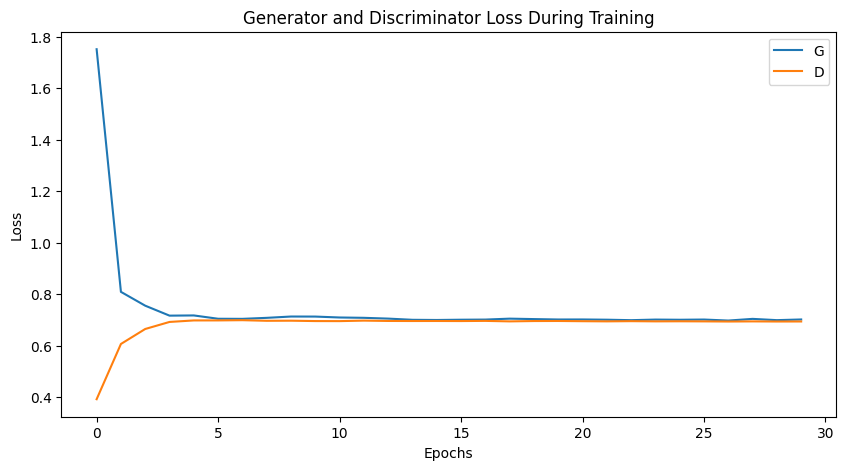

----------------------------------------------------------------------------------------------------
Epoch: 0
	Train
		G Loss: 0.70715493937723,	D Loss: 0.6949162198827158
	Valid
		G Loss: 0.7154637254201449, 	 D Loss: 0.6875616388443189
----------------------------------------------------------------------------------------------------
Epoch: 1
	Train
		G Loss: 0.7175732352375205,	D Loss: 0.687575702184166
	Valid
		G Loss: 0.6164233730389521, 	 D Loss: 0.6855300450936342
----------------------------------------------------------------------------------------------------
Epoch: 2
	Train
		G Loss: 0.7104200070200403,	D Loss: 0.6965885512969073
	Valid
		G Loss: 0.7169641699546423, 	 D Loss: 0.6915321487646836
----------------------------------------------------------------------------------------------------
Epoch: 3
	Train
		G Loss: 0.7049851370792762,	D Loss: 0.6955920438361324
	Valid
		G Loss: 0.6602717958963834, 	 D Loss: 0.6835234562555949
-------------------------------------------

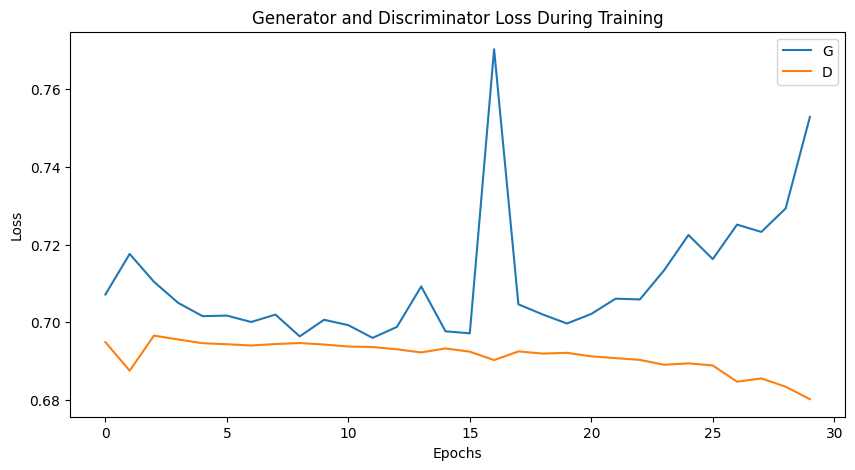

----------------------------------------------------------------------------------------------------
Epoch: 0
	Train
		G Loss: 0.7562228721730849,	D Loss: 0.6782091041795568
	Valid
		G Loss: 0.7232415920648819, 	 D Loss: 0.6801250852071322
----------------------------------------------------------------------------------------------------
Epoch: 1
	Train
		G Loss: 0.743820543382682,	D Loss: 0.681028787217109
	Valid
		G Loss: 0.610025289731148, 	 D Loss: 0.6838634671309055
----------------------------------------------------------------------------------------------------
Epoch: 2
	Train
		G Loss: 0.7344857337428075,	D Loss: 0.6840132272321414
	Valid
		G Loss: 0.6616876369867569, 	 D Loss: 0.6912732720375061
----------------------------------------------------------------------------------------------------
Epoch: 3
	Train
		G Loss: 0.7319494139135273,	D Loss: 0.684322766618791
	Valid
		G Loss: 0.7100527317096026, 	 D Loss: 0.683756444698725
---------------------------------------------

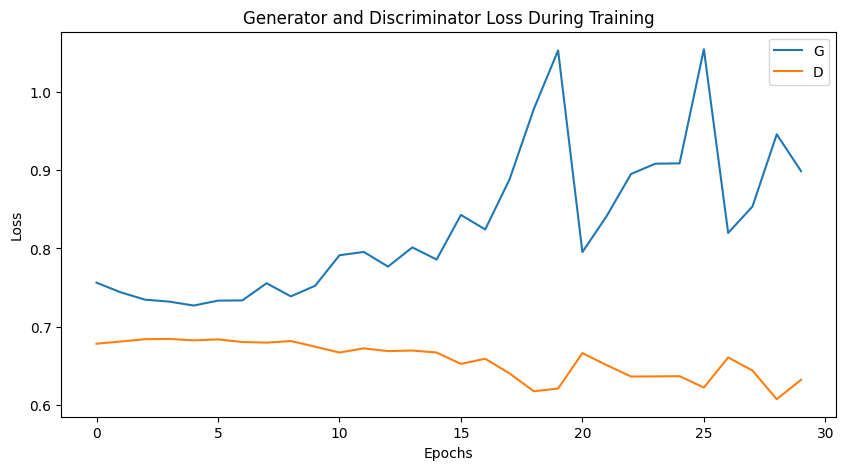

----------------------------------------------------------------------------------------------------
Epoch: 0
	Train
		G Loss: 0.9062399104529736,	D Loss: 0.6361629941494636
	Valid
		G Loss: 0.9036910870136359, 	 D Loss: 0.5772301287223132
----------------------------------------------------------------------------------------------------
Epoch: 1
	Train
		G Loss: 1.0251129978622486,	D Loss: 0.5977923552584804
	Valid
		G Loss: 0.8331847007458026, 	 D Loss: 0.6813180362566923
----------------------------------------------------------------------------------------------------
Epoch: 2
	Train
		G Loss: 0.9919143455480438,	D Loss: 0.5966051468272614
	Valid
		G Loss: 0.9988626791880681, 	 D Loss: 0.6239717877828158
----------------------------------------------------------------------------------------------------
Epoch: 3
	Train
		G Loss: 0.932689381191154,	D Loss: 0.6150282135391547
	Valid
		G Loss: 0.7250057917374831, 	 D Loss: 0.6036106401529068
-----------------------------------------

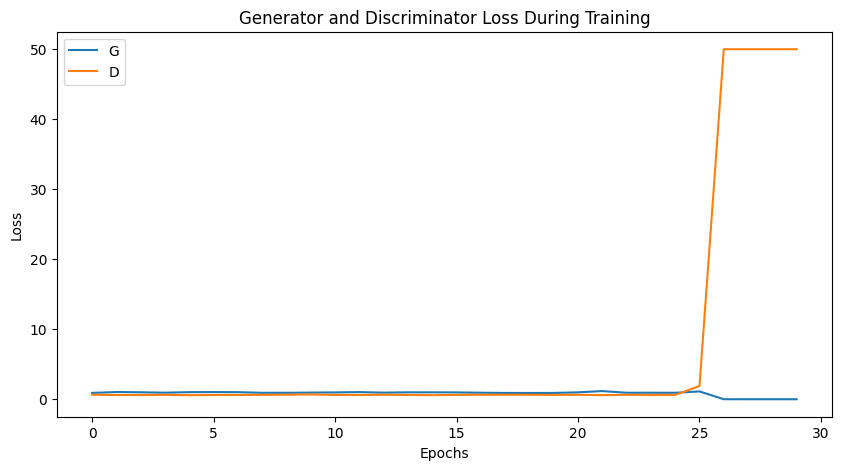

----------------------------------------------------------------------------------------------------
Epoch: 0
	Train
		G Loss: 0.0,	D Loss: 50.0
	Valid
		G Loss: 0.0, 	 D Loss: 50.0
----------------------------------------------------------------------------------------------------
Epoch: 1
	Train
		G Loss: 0.0,	D Loss: 50.0
	Valid
		G Loss: 0.0, 	 D Loss: 50.0
----------------------------------------------------------------------------------------------------
Epoch: 2
	Train
		G Loss: 0.0,	D Loss: 50.0
	Valid
		G Loss: 0.0, 	 D Loss: 50.0
----------------------------------------------------------------------------------------------------
Epoch: 3
	Train
		G Loss: 0.0,	D Loss: 50.0
	Valid
		G Loss: 0.0, 	 D Loss: 50.0
----------------------------------------------------------------------------------------------------
Epoch: 4
	Train
		G Loss: 0.0,	D Loss: 50.0
	Valid
		G Loss: 0.0, 	 D Loss: 50.0
------------------------------------------------------------------------------------------

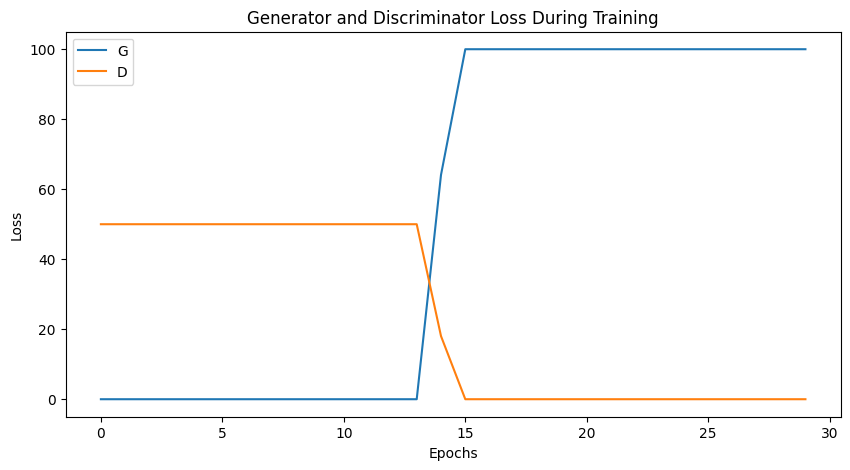

----------------------------------------------------------------------------------------------------
Epoch: 0
	Train
		G Loss: 100.0,	D Loss: 0.0
	Valid
		G Loss: 100.0, 	 D Loss: 0.0
----------------------------------------------------------------------------------------------------
Epoch: 1
	Train
		G Loss: 100.0,	D Loss: 0.0
	Valid
		G Loss: 100.0, 	 D Loss: 0.0
----------------------------------------------------------------------------------------------------
Epoch: 2
	Train
		G Loss: 100.0,	D Loss: 0.0
	Valid
		G Loss: 100.0, 	 D Loss: 0.0
----------------------------------------------------------------------------------------------------
Epoch: 3
	Train
		G Loss: 100.0,	D Loss: 0.0
	Valid
		G Loss: 100.0, 	 D Loss: 0.0
----------------------------------------------------------------------------------------------------
Epoch: 4
	Train
		G Loss: 100.0,	D Loss: 0.0
	Valid
		G Loss: 100.0, 	 D Loss: 0.0
--------------------------------------------------------------------------------

KeyboardInterrupt: ignored

In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
import gc
import matplotlib.pyplot as plt
from torchvision.utils import save_image


resolution_list = ["4x4", "8x8", "16x16", "32x32", "64x64", "128x128", "256x256"]
dataset_path = [f"./dataset/{i}" for i in resolution_list]
model_state_dict_path = [f"./model_state_dict/{i}" for i in resolution_list]



class Trainer():

    def __init__(self,
                steps: int,
                batch_size: int,
                device: torch.device,
                test_size: int
            ):

        self.steps = steps
        self.batch_size = batch_size
        self.device = device
        self.test_size = test_size

        directory_path = dataset_path[self.steps]

        self.trainloader = DataLoader(torch.load(f"{directory_path}/train_defect4.pt").type(torch.float32), batch_size=self.batch_size, shuffle=True)
        self.validloader = DataLoader(torch.load(f"{directory_path}/valid_defect4.pt").type(torch.float32), batch_size=self.batch_size, shuffle=True)


        self.generator = Generator(steps=self.steps).to(self.device)
        self.discriminator = Discriminator(steps=self.steps).to(self.device)

        self.criterion = nn.BCELoss()
        self.generator_optim = Adam(self.generator.parameters(), lr=0.002, betas=(0.5, 0.999))
        self.discriminator_optim = Adam(self.discriminator.parameters(), lr=0.002, betas=(0.5, 0.999))

        # It will be used for testing.
        self.test_z = torch.randn((self.test_size, 128, 1, 1)).to(self.device)

        self.load_model()


    def save_model(self):

         
        generator_dir = f"{model_state_dict_path[self.steps]}/generator_model"
        discriminator_dir = f"{model_state_dict_path[self.steps]}/discriminator_model"

        if not os.path.exists(generator_dir):
            os.makedirs(generator_dir)

        if not os.path.exists(discriminator_dir):
            os.makedirs(discriminator_dir)

            # ------------------------------------------------------------------ generator model ---------------------------------------------------------------------------
        for i in range(self.steps+1):
            torch.save(self.generator.prog_blocks[i].state_dict(), f"{generator_dir}/prog_blocks_{i}.pt")
            torch.save(self.generator.torgb_layers[i].state_dict(), f"{generator_dir}/torgb_layers_{i}.pt")

        # ---------------------------------------------------------------- discriminator model -------------------------------------------------------------------------
        for i in range(self.steps+1):
            torch.save(self.discriminator.prog_blocks[i].state_dict(), f"{discriminator_dir}/prog_blocks_{i}.pt")
            torch.save(self.discriminator.fromrgb_layers[i].state_dict(), f"{discriminator_dir}/fromrgb_layers_{i}.pt")




    def load_model(self):
        if self.steps == 0:
            return

        
        generator_dir = f"{model_state_dict_path[self.steps-1]}/generator_model"
        discriminator_dir = f"{model_state_dict_path[self.steps-1]}/discriminator_model"

        if not os.path.exists(generator_dir) or not os.path.exists(discriminator_dir):
            print("The required directories do not exist. Please check your paths.")
            return

        # ------------------------------------------------------------------ generator model ---------------------------------------------------------------------------
        for i in range(self.steps):
            self.generator.prog_blocks[i].load_state_dict(torch.load(f"{generator_dir}/prog_blocks_{i}.pt"))
            self.generator.torgb_layers[i].load_state_dict(torch.load(f"{generator_dir}/torgb_layers_{i}.pt"))

        # ---------------------------------------------------------------- discriminator model -------------------------------------------------------------------------
        for i in range(1, self.steps+1):
            self.discriminator.prog_blocks[i].load_state_dict(torch.load(f"{discriminator_dir}/prog_blocks_{i-1}.pt"))
            self.discriminator.fromrgb_layers[i].load_state_dict(torch.load(f"{discriminator_dir}/fromrgb_layers_{i-1}.pt"))





    def clear_cuda_memory(self):
        gc.collect()
        torch.cuda.empty_cache()


    def test(self, epoch):
        self.generator.eval()
        self.discriminator.eval()

        pred = self.generator(self.test_z, alpha=self.alpha)
        pred = pred.detach().cpu()

        test_image = merge_test_pred(pred)
        test_image.save(fp=f"./train_log/{resolution_list[self.steps]}/epoch-{epoch}.jpg")


    def train(self):
        self.generator.train()
        self.discriminator.train()

        generator_avg_loss = 0
        discriminator_avg_loss = 0

        for _ in range(len(self.trainloader)):
            self.alpha += self.alpha_gap

            real_image = next(iter(self.trainloader)).to(self.device)

            real_label = torch.full((real_image.size(0), 1), 1).type(torch.float).to(self.device)
            fake_label = torch.full((real_image.size(0), 1), 0).type(torch.float).to(self.device)

            # ---------------------------------------------------------- discriminator train ------------------------------------------------------------
            z = torch.randn(real_image.size(0), 128, 1, 1).to(self.device)

            fake_image = self.generator(z, alpha=self.alpha)

            d_fake_pred = self.discriminator(fake_image, alpha=self.alpha)
            d_fake_loss = self.criterion(d_fake_pred, fake_label)

            d_real_pred = self.discriminator(real_image, alpha=self.alpha)
            d_real_loss = self.criterion(d_real_pred, real_label)

            d_loss = d_fake_loss + d_real_loss

            self.discriminator_optim.zero_grad()
            d_loss.backward()
            self.discriminator_optim.step()

            discriminator_avg_loss += (d_loss.item() / 2)

            # ---------------------------------------------------------- generator train -----------------------------------------------------------------
            z = torch.randn(real_image.size(0), 128, 1, 1).to(self.device)

            fake_image = self.generator(z, alpha=self.alpha)

            d_fake_pred = self.discriminator(fake_image, alpha=self.alpha)
            g_loss = self.criterion(d_fake_pred, real_label)

            self.generator_optim.zero_grad()
            g_loss.backward()
            self.generator_optim.step()

            generator_avg_loss += g_loss.item()


            self.clear_cuda_memory()

        generator_avg_loss /= len(self.trainloader)
        discriminator_avg_loss /= len(self.trainloader)

        return generator_avg_loss, discriminator_avg_loss


    def valid(self):
        self.generator.eval()
        self.discriminator.eval()

        generator_avg_loss = 0
        discriminator_avg_loss = 0

        for _ in range(len(self.validloader)):
            real_image = next(iter(self.validloader)).to(self.device)

            real_label = torch.full((real_image.size(0), 1), 1).type(torch.float).to(self.device)
            fake_label = torch.full((real_image.size(0), 1), 0).type(torch.float).to(self.device)

            # ----------------------------------------------------- discriminator valid ----------------------------------------------------------------

            z = torch.randn((real_image.size(0), 128, 1, 1)).to(self.device)
            fake_image = self.generator(z, alpha=self.alpha)

            d_fake_pred = self.discriminator(fake_image.detach(), alpha=self.alpha)
            d_fake_loss = self.criterion(d_fake_pred, fake_label)

            d_real_pred = self.discriminator(real_image, alpha=self.alpha)
            d_real_loss = self.criterion(d_real_pred, real_label)

            discriminator_avg_loss += ((d_fake_loss + d_real_loss).item() / 2)

            # ------------------------------------------------------ generator valid --------------------------------------------------------------------

            z = torch.randn((real_image.size(0), 128, 1, 1)).to(self.device)
            fake_image = self.generator(z, alpha=self.alpha)

            d_fake_pred = self.discriminator(fake_image.detach(), alpha=self.alpha)
            g_loss = self.criterion(d_fake_pred, real_label)

            generator_avg_loss += g_loss.item()

            self.clear_cuda_memory()

        generator_avg_loss /= len(self.validloader)
        discriminator_avg_loss /= len(self.validloader)

        return generator_avg_loss, discriminator_avg_loss


    def run(self, epochs):
        train_history = []
        valid_history = []

        self.alpha = 0
        self.alpha_gap = 1 / (len(self.trainloader) * (epochs[1] - epochs[0]))

        for epoch in range(*epochs):
            print("-"*100 + "\n" + f"Epoch: {epoch}")

            train_history.append(self.train())
            print(f"\tTrain\n\t\tG Loss: {train_history[-1][0]},\tD Loss: {train_history[-1][1]}")

            valid_history.append(self.valid())
            print(f"\tValid\n\t\tG Loss: {valid_history[-1][0]}, \t D Loss: {valid_history[-1][1]}")

            self.test(epoch)

        return train_history, valid_history


#이미지 생성 코드
def generate_and_save_images(self, num_images: int, path: str):
        self.generator.eval()

        if not os.path.exists(path):
            os.makedirs(path)

        with torch.no_grad():
            for i in range(num_images):
                z = torch.randn(1, 128, 1, 1).to(self.device)
                fake_image = self.generator(z, alpha=1.0) 
                save_image(fake_image * 0.5 + 0.5 , f"{path}/image_{i+1}.png") 

        self.generator.train()


if __name__ == '__main__':
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for steps in range(7):
        trainer = Trainer(steps=steps, batch_size=16, device=device, test_size=16)
        train_history, valid_history = trainer.run((0, 30))
        if steps == 6:
            trainer.generate_and_save_images(num_images=1000,
                                             path=f"./defect_pggan_generated_images/{resolution_list[steps]}")
        trainer.save_model()

        #Loss그래프 그리기
        train_g_losses = [x[0] for x in train_history]
        train_d_losses = [x[1] for x in train_history]

        plt.figure(figsize=(10,5))
        plt.title("Generator and Discriminator Loss During Training")
        plt.plot(train_g_losses,label="G")
        plt.plot(train_d_losses,label="D")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

아래는 학습 도중 생성한 이미지로 이미지와 gif를 만드는 코드다.

In [ ]:
from PIL import Image
from torchvision import transforms
import os
import torch
import numpy as np



class Dataset:

    def __init__(self, directory_list, resolution):
        self.directory_list = directory_list
        self.resolution = resolution


    def image_to_tensor(self, path, res):
        #img = Image.open(path).resize(res)
        img = Image.open(path).convert('L').resize(res)  # convert to grayscale

        tensor_img = transforms.ToTensor()(img)
        tensor_img = tensor_img.type(torch.float16)

        return tensor_img


    def dataset_to_tensor(self, directory_path):
        files = os.listdir(directory_path)
        tensor_dataset = torch.zeros((len(files), 1, *self.resolution)).type(torch.float16)

        for i in range(len(files)):
            tensor_dataset[i] = self.image_to_tensor(f"{directory_path}/{files[i]}", self.resolution)

        return tensor_dataset


    def extract_dataset(self):
        dataset_pair = []

        for directory_path in self.directory_list:
            dataset_pair.append(self.dataset_to_tensor(directory_path))

        return dataset_pair



def make_gif(paths, save_path, fps=500):
    img, *imgs = [Image.open(path) for path in paths]
    img.save(fp=save_path, format="GIF", append_images=imgs, save_all=True, duration=fps, loop=1)


def merge_test_pred(pred):

    test_size = pred.size(0)

    # ex) test_size = 30 -> height = 5, weight = 6
    for i in range(int(np.sqrt(test_size)), test_size+1):
        if test_size % i == 0:
            n_height = max(i, test_size//i)
            n_weight = min(i, test_size//i)
            break

    image_size = (
        1024 - (1024 % n_weight),
        1024 - (1024 % n_height)
    )

    one_image_size = (image_size[0] // n_weight, image_size[1] // n_height)

    image = Image.new('L', image_size)

    for w in range(n_weight):
        for h in range(n_height):
            img = transforms.ToPILImage()(pred[n_height*w + h])
            img = img.resize(one_image_size)

            image.paste(img, (one_image_size[0] * w, one_image_size[1] * h))

    return image



if __name__ == "__main__":

    resolution_list = ["4x4", "8x8", "16x16", "32x32", "64x64", "128x128", "256x256"]
    for resolution in resolution_list:

        # ex) 4x4 -> (4, 4)
        resolution_pair = tuple(map(int, resolution.split("x")))

        dataset = Dataset(
            directory_list=["./dataset/train/defect4", "./dataset/val/defect4"],
            resolution=resolution_pair
        )

        train_data, valid_data = dataset.extract_dataset()
        # Check if the directories exist and create them if necessary
        train_dir = f"./dataset/{resolution}"
        valid_dir = f"./dataset/{resolution}"

        if not os.path.exists(train_dir):
            os.makedirs(train_dir)

        if not os.path.exists(valid_dir):
            os.makedirs(valid_dir)

        torch.save(train_data, f"{train_dir}/train_defect4.pt")
        torch.save(valid_data, f"{valid_dir}/valid_defect4.pt")




    # ------------- make train log gif file -----------------------
    resolution_list = ["4x4", "8x8", "16x16", "32x32", "64x64", "128x128", "256x256"]
    train_log_file_list = []

    cnt = 0

    for resolution in resolution_list:
        directory = f"./train_log/{resolution}"
        
        if not os.path.exists(directory):
            os.makedirs(directory)

        for file_name in os.listdir(directory):
            current_epoch = int(file_name.replace("epoch-", "").replace(".jpg", ""))
            train_log_file_list.append((cnt + current_epoch, f"{directory}/{file_name}"))

        cnt += len(os.listdir(directory))

    train_log_file_list.sort(key=lambda x: x[0])
    train_log_file_list = [i[1] for i in train_log_file_list]

    for i in range(10):
        train_log_file_list.append(train_log_file_list[-1])

    gif_directory = "./train_log"
    if not os.path.exists(gif_directory):
        os.makedirs(gif_directory)

    make_gif(train_log_file_list, f"{gif_directory}/train.gif", 2)

